In [1]:
import geopandas as gpd
import ee, eemont
import geemap
import pandas as pd
import random
import shapely
from bisonlab.data import landsat_7_sr, landsat_8_sr, landsat_9_sr, s2_sr_harmonized
from bisonlab.io import kml_to_geodataframe, kmz_to_geodataframe
from bisonlab.data import LOCAL_DATA_DIR, DATA_DIR
from bisonlab.utils import mask_include, mask_exclude
from pathlib import Path
import datetime as dt
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
random.seed(123)

In [3]:
ee.Initialize()

In [4]:
crs = "EPSG:5070"

# Parcels

In [5]:
# Open buffalo expansion geometries
filepath = DATA_DIR / "Buffalo Expansion.kmz"
df_parcels = kmz_to_geodataframe(filepath)
df_parcels = df_parcels.drop(columns="Description")
df_parcels = df_parcels.rename(columns={"Name": "name"})

# Select subset of parcels
parcels_of_interest = [
    "Shoshone Tribe",
    "Hellyer Place",
    "Hellyer Tribal Lease",
    "Buffalo Initiative",
    "Wickstram Property",
    "Hoopengarner Property",
    # "Adels Property",
    # "T3000, Unassigned Leases"
]

df_parcels = df_parcels.loc[df_parcels.name.isin(parcels_of_interest)].reset_index(drop=True)

# df_parcels["parcel_id"] = range(1,len(df_parcels) + 1)

df_parcels = df_parcels.to_crs(crs=crs)

In [6]:
# shoshone_tribe_subplots
filepath = DATA_DIR / "shoshone_tribe_subplots.kml"
df_shoshone_tribe_subplots = kml_to_geodataframe(filepath)
df_shoshone_tribe_subplots.drop(columns=["Description", "layer"], inplace=True)
df_shoshone_tribe_subplots.rename(columns={"Name": "name"}, inplace=True)
df_shoshone_tribe_subplots = df_shoshone_tribe_subplots.to_crs(crs=crs)
df_shoshone_tribe_subplots = df_shoshone_tribe_subplots.replace('plot1', 'shoshone_tribe_subplot_1')
df_shoshone_tribe_subplots = df_shoshone_tribe_subplots.replace('plot2', 'shoshone_tribe_subplot_2')

In [7]:
# df_parcels = df_parcels.append(df_shoshone_tribe_subplots).reset_index(drop=True)

In [8]:
df_parcels

,name,geometry
0,Shoshone Tribe,"POLYGON ((-1030780.069 2315216.076, -1031458.9..."
1,Buffalo Initiative,"POLYGON ((-1030879.596 2314660.898, -1030804.4..."
2,Hellyer Place,"POLYGON ((-1031247.137 2316088.631, -1031631.6..."
3,Hoopengarner Property,"POLYGON ((-1033675.378 2315580.516, -1034449.3..."
4,Wickstram Property,"POLYGON ((-1034850.377 2315736.106, -1034457.3..."
5,Hellyer Tribal Lease,"POLYGON ((-1031801.689 2314930.485, -1032203.5..."


In [9]:
# Convert parcels dataframe to ee.featureCollection
parcels = geemap.geopandas_to_ee(df_parcels)

In [10]:
parcel_labels = list(df_parcels.name)
parcel_colors = [f"{random.randint(0, 0xFFFFFF):06x}" for i in range(len(df_parcels))]
parcels_styled = geemap.ee_vector_style(
    parcels, column='name', labels=parcel_labels,
    fillColor='00000000', color=parcel_colors, width=5
)

In [11]:
# Get maximum bounds of all parcels
parcel_bounds = parcels.geometry().dissolve().bounds()
parcel_bounds_shapely = df_parcels.dissolve().geometry.item()

/Users/chill/software/miniconda3/envs/bison-lab/lib/python3.10/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


# Remote Sensing / Soil Data Layers

### Terrain
* Elevation / DEM
    - [USGS_3DEP_1m](https://developers.google.com/earth-engine/datasets/catalog/USGS_3DEP_1m)
    - `1 m` resolution

In [12]:
# Compute terrain properties from DEM
dem = ee.ImageCollection("USGS/3DEP/1m").filterBounds(parcel_bounds)

terrain = dem.map(ee.Terrain.products).mosaic()

elevation = terrain.select('elevation')

# Slope units are degrees, range is [0,90)
slope = terrain.select('slope')

# Aspect units are degrees where 0=N, 90=E, 180=S, 270=W
aspect = terrain.select('aspect')

# Hillshade is calculated based on illumination azimuth=270, elevation=45
hillshade = terrain.select('hillshade')

#### Properties of parcels

In [13]:
mm = terrain.reduceRegions(collection=parcels, reducer=ee.Reducer.minMax(), scale=1, tileScale=4)

In [14]:
geemap.ee_to_df(mm)

,elevation_min,elevation_max,slope_min,slope_max,aspect_min,aspect_max,hillshade_min,hillshade_max,name
0,1646.006226,1686.382324,0,56,0,359,81,255,Shoshone Tribe
1,1647.123901,1684.201050,0,56,0,359,80,255,Buffalo Initiative
2,1659.830811,1692.644775,0,63,0,359,100,255,Hellyer Place
3,1653.168945,1660.648682,0,41,0,359,116,247,Hoopengarner Property
4,1657.599121,1666.955078,0,44,0,359,67,255,Wickstram Property
5,1645.551147,1681.574219,0,55,0,359,59,255,Hellyer Tribal Lease


### Soil taxonomy
* sourced from SSURGO

In [15]:
df_soil_taxonomy = gpd.read_parquet(DATA_DIR / "soil_taxonomy.parquet") 
df_soil_taxonomy = df_soil_taxonomy.to_crs(crs=crs)

# Only include map units that intersect parcels
df_soil_taxonomy = df_soil_taxonomy[df_soil_taxonomy.intersects(parcel_bounds_shapely)]

unique_soil = list(df_soil_taxonomy['MUSYM'].unique())
soil_taxonomy_map = dict(zip(unique_soil, range(1, len(unique_soil) + 1))) 
df_soil_taxonomy["soil_id"] = df_soil_taxonomy.MUSYM.map(soil_taxonomy_map)

/Users/chill/software/miniconda3/envs/bison-lab/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


In [16]:
soil_taxonomy = geemap.geopandas_to_ee(df_soil_taxonomy)

In [17]:
soil_taxonomy_labels = unique_soil
soil_taxonomy_colors = [f"{random.randint(0, 0xFFFFFF):06x}" for i in range(len(soil_taxonomy_labels))]
soil_taxonomy_styled = geemap.ee_vector_style(
    soil_taxonomy, column='MUSYM', labels=soil_taxonomy_labels, fillColor=soil_taxonomy_colors, color='00000000'
)

In [32]:
pd.set_option('display.max_colwidth', None)

In [33]:
df_soil_taxonomy.loc[:, ["MUSYM", "desc"]].drop_duplicates()

,MUSYM,desc
41,CRF,"Clifterson-Rock land association, steep"
72,Cw,"Crowheart loam, 0 to 3 percent slopes, occasionally flooded"
119,EtB,"Ethete loam, 3 to 6 percent slopes"
125,ZZ900,Water
138,GrA,"Griffy loam, 0 to 3 percent slopes"
154,Bg,"Bigwin fine sandy loam, 0 to 2 percent slopes, frequently flooded"
190,FnA,"Fivemile silty clay loam, 0 to 3 percent slopes"
202,PaC,"Pavillion sandy clay loam, 3 to 10 percent slopes"
247,Wa,Wet alluvial land
259,EtA,"Ethete loam, 0 to 3 percent slopes"


## Soil properties
* Sourced from gSSURGO

In [19]:
params = ['clay_fraction', 'sand_fraction', 'silt_fraction', 'bdod', 'phh2o', 'som_percent', 'soc_percent']

In [20]:
soil = {param: ee.Image(f"projects/bison-lab/assets/{param}") for param in params}

In [21]:
def usda_soil_class_ee(sand: ee.Image = None, silt: ee.Image = None, clay: ee.Image = None) -> ee.Image:
    """
    Takes images of sand/silt/clay percentage and returns USDA soil class (texture triangle)
    https://www.nrcs.usda.gov/sites/default/files/2022-09/The-Soil-Survey-Manual.pdf page 122

    1  "Sa": "sand"
    2  "LoSa": "loamy sand"
    3  "SaLo": "sandy loam"
    4  "Lo": "loam"
    5  "SiLo": "silty loam"
    6  "Si": "silt"
    7  "SaClLo": "sandy clay loam"
    8  "ClLo": "clay loam"
    9  "SiClLo": "silty clay loam"
    10  "SaCl": "sandy clay"
    11  "SiCl": "silty clay"
    12  "Cl": "clay"

    Args:
        sand: Image of sand percentage
        silt: Image of silt percentage
        clay: Image of clay percentage

    Returns:
        Image of soil class
    """
    # Initialize soil class image with crs and crsTransform from `sand` image,
    # and set to be the same as that applied to `sand` image
    soil_class = (
        ee.Image(0)
        .setDefaultProjection(crs=sand.projection().wkt(), crsTransform=sand.getInfo()["bands"][0]["crs_transform"])
        .updateMask(sand)
    )

    # Sand - Material has more than 85 percent sand, and the percentage of silt plus
    # 1.5 times the percentage of clay is less than 15.
    soil_class = soil_class.where(sand.gt(85).And(silt.add(clay.multiply(1.5)).lt(15)), 1)
    # Loamy sands - Material has between 70 and 90 percent sand, the
    # percentage of silt plus 1.5 times the percentage of clay is 15 or more, and
    # the percentage of silt plus twice the percentage of clay is less than 30.
    soil_class = soil_class.where(
        sand.gte(70).And(sand.lte(90)).And(silt.add(clay.multiply(1.5)).gte(15)).And(silt.add(clay.multiply(2)).lt(30)),
        2,
    )
    # Sandy loams - Material has 7 to less than 20 percent clay and more
    # than 52 percent sand, and the percentage of silt plus twice the percentage
    # of clay is 30 or more; OR material has less than 7 percent clay and less
    # than 50 percent silt, and the percentage of silt plus twice the percentage
    # of clay is 30 or more.
    soil_class = soil_class.where(
        (clay.gte(7).And(clay.lt(20)).And(sand.gt(52)).And(silt.add(clay.multiply(2)).gte(30))).Or(
            (clay.lt(7).And(silt.lt(50)).And(silt.add(clay.multiply(2)).gte(30)))
        ),
        3,
    )
    # Loam - Material has 7 to less than 27 percent clay, 28 to less than
    # 50 percent silt, and 52 percent or less sand.
    soil_class = soil_class.where(clay.gte(7).And(clay.lt(27)).And(silt.gte(28)).And(silt.lt(50)).And(sand.lte(52)), 4)
    # Silt loam - Material has 50 percent or more silt and 12 to less than
    # 27 percent clay; OR material has 50 to less than 80 percent silt and less
    # than 12 percent clay.
    soil_class = soil_class.where(
        (silt.gte(50).And(clay.gte(12)).And(clay.lt(27))).Or((silt.gte(50).And(silt.lt(80)).And(clay.lt(12)))), 5
    )
    # Silt - Material has 80 percent or more silt and less than 12 percent
    # clay.
    soil_class = soil_class.where(silt.gte(80).And(clay.lt(12)), 6)
    # Sandy clay loam - Material has 20 to less than 35 percent clay, less
    # than 28 percent silt, and more than 45 percent sand.
    soil_class = soil_class.where(clay.gte(20).And(clay.lt(35)).And(silt.lt(28)).And(sand.gt(45)), 7)
    # Clay loam - Material has 27 to less than 40 percent clay and more
    # than 20 to 45 percent sand.
    soil_class = soil_class.where((clay.gte(27).And(clay.lt(40)).And(sand.gt(20)).And(sand.lte(45))), 8)
    # Silty clay loam - Material has 27 to less than 40 percent clay and 20
    # percent or less sand.
    soil_class = soil_class.where((clay.gte(27).And(clay.lt(40)).And(sand.lte(20))), 9)
    # Sandy clay - Material has 35 percent or more clay and more than
    # 45 percent sand.
    soil_class = soil_class.where(clay.gte(35).And(sand.gt(45)), 10)
    # Silty clay - Material has 40 percent or more clay and 40 percent or
    # more silt.
    soil_class = soil_class.where(clay.gte(40).And(silt.gte(40)), 11)
    # Clay - Material has 40 percent or more clay, 45 percent or less sand,
    # and less than 40 percent silt.
    soil_class = soil_class.where(clay.gte(40).And(sand.lte(45)).And(silt.lt(40)), 12)

    # Mask out null values
    soil_class = soil_class.selfMask()

    return soil_class.rename("texture")

In [22]:
USDA_SOIL_CLASS = {
    1: 'sand',
    2: 'loamy sand',
    3: 'sandy loam',
    4: 'loam',
    5: 'silty loam',
    6: 'silt',
    7: 'sandy clay loam',
    8: 'clay loam',
    9: 'silty clay loam',
    10: 'sandy clay',
    11: 'silty clay',
    12: 'clay'
}

In [23]:
texture = usda_soil_class_ee(soil['sand_fraction'] * 100.0, soil['silt_fraction'] * 100.0, soil['clay_fraction'] * 100.0)

### Irrigation
* GFSAD Landsat-Derived Global Rainfed and Irrigated-Cropland Product (LGRIP)
    - `https://gee-community-catalog.org/projects/lgrip30/`

In [25]:
irrigation = ee.ImageCollection("projects/sat-io/open-datasets/GFSAD/LGRIP30").filterBounds(parcel_bounds)

# Class Label, Name, Description
# 0 Ocean, Ocean and Water bodies
# 1 Non-croplands, Land with other land use
# 2 Irrigated croplands, Agricultural croplands that are irrigated
# 3 Rainfed croplands, Agricultural croplands that are rainfed

irrigation_colors = ["0050cb","d58855","c2d30c","379a4b"]
irrigation_labels = ["Ocean", "Non-croplands", "Irrigated croplands", "Rainfed croplands"]
irrigation_vis = {"min": 0, "max": 3, "palette": irrigation_colors}

## Plot all remote sensing layers

In [26]:
parcel_bounds.area(1).getInfo()

16066027.417800728

In [27]:
# m = geemap.Map()
# for param, img in soil.items():
#     m.addLayer(img, {}, param)
# m.addLayer(parcels_styled, {}, "Parcels")
# m.centerObject(parcels, 14)
# m

In [46]:
legend_dict = {
    '11 Open Water': '466b9f',
    '12 Perennial Ice/Snow': 'd1def8',
    '21 Developed, Open Space': 'dec5c5',
    '22 Developed, Low Intensity': 'd99282',
    '23 Developed, Medium Intensity': 'eb0000',
    '24 Developed High Intensity': 'ab0000',
    '31 Barren Land (Rock/Sand/Clay)': 'b3ac9f',
    '41 Deciduous Forest': '68ab5f',
    '42 Evergreen Forest': '1c5f2c',
    '43 Mixed Forest': 'b5c58f',
    '51 Dwarf Scrub': 'af963c',
    '52 Shrub/Scrub': 'ccb879',
    '71 Grassland/Herbaceous': 'dfdfc2',
    '72 Sedge/Herbaceous': 'd1d182',
    '73 Lichens': 'a3cc51',
    '74 Moss': '82ba9e',
    '81 Pasture/Hay': 'dcd939',
    '82 Cultivated Crops': 'ab6c28',
    '90 Woody Wetlands': 'b8d9eb',
    '95 Emergent Herbaceous Wetlands': '6c9fb8',
}


In [58]:
list(legend_dict.values())[8:]

['1c5f2c',
 'b5c58f',
 'af963c',
 'ccb879',
 'dfdfc2',
 'd1d182',
 'a3cc51',
 '82ba9e',
 'dcd939',
 'ab6c28',
 'b8d9eb',
 '6c9fb8']

In [59]:
soil_texture_colors = [
'1c5f2c',
 'b5c58f',
 'af963c',
 'ccb879',
 'dfdfc2',
 'd1d182',
 'a3cc51',
 '82ba9e',
 'dcd939',
 'ab6c28',
 'b8d9eb',
 '6c9fb8'
]
    # [f"{random.randint(0, 0xFFFFFF):06x}" for i in range(len(USDA_SOIL_CLASS))]

In [60]:
texture_vis = {
    'min': 1,
    'max': 12,
    'palette':soil_texture_colors
}

In [62]:
USDA_SOIL_CLASS

{1: 'sand',
 2: 'loamy sand',
 3: 'sandy loam',
 4: 'loam',
 5: 'silty loam',
 6: 'silt',
 7: 'sandy clay loam',
 8: 'clay loam',
 9: 'silty clay loam',
 10: 'sandy clay',
 11: 'silty clay',
 12: 'clay'}

In [61]:
m = geemap.Map(height=800)
m.addLayer(texture, texture_vis, 'Texture')
m.add_legend(title="Texture", labels=list(USDA_SOIL_CLASS.values()), colors=soil_texture_colors, position="bottomright")

m.addLayer(parcels_styled, {}, "Parcels")
m.add_legend(title='parcels', labels=parcel_labels, colors=parcel_colors, position="bottomleft")

m.centerObject(parcels, 14)
m

Map(center=[43.204169357387904, -108.81022736175909], controls=(WidgetControl(options=['position', 'transparen…

In [63]:
m = geemap.Map(height=800)

m.addLayer(slope, {"min": 0, "max": 89.99}, 'Slope')
m.addLayer(slope.lt(10), {}, 'Slope < 10 deg')
# m.addLayer(aspect, {"min": 0, "max": 359.99}, 'Aspect')
m.addLayer(hillshade, {"min": 0, "max": 255}, 'Hillshade')

m.addLayer(soil_taxonomy_styled, {}, 'Soil Taxonomy')
# m.add_legend(title="Soil group", labels=soil_taxonomy_labels, colors=soil_taxonomy_colors, position="bottomright")

m.addLayer(irrigation, irrigation_vis, "Irrigated")
# m.add_legend(title='Irrigation', labels=irrigation_labels, colors=irrigation_colors, position="topleft")

m.addLayer(texture, texture_vis, 'Texture')
m.add_legend(title="Texture", labels=list(USDA_SOIL_CLASS.values()), colors=soil_texture_colors, position="topleft")

m.addLayer(parcels_styled, {}, "Parcels")
# m.add_legend(title='parcels', labels=parcel_labels, colors=parcel_colors, position="bottomleft")

m.centerObject(parcels, 14)
m

Map(center=[43.204169357387904, -108.81022736175909], controls=(WidgetControl(options=['position', 'transparen…

# Intersect soil properties with parcels 
* We want only regions with `slope < 10 deg`
* Same soil type in parcel boundaries

In [102]:
# Select comparison plot boundaries
parcels_comparison = parcels.filter(ee.Filter.inList("name", ["shoshone_tribe_subplot_1", "shoshone_tribe_subplot_2", "Hellyer Place", "Hoopengarner Property"]))

In [328]:
# Mask for slope
slope_mask = slope.lt(10)

In [104]:
# This calculated the number of pixels of each texture class per parcel
# soil_texture_stats = soil['texture'].reduceRegions(
#     collection=parcels_comparison, reducer=ee.Reducer.frequencyHistogram(), scale=30
# )
# geemap.ee_to_df(soil_texture_stats)

In [329]:
# We are interested in soil texture 2 = USDA_SOIL_CLASS[2] = 'silty clay' as this has the maximum intersection with our comparison plots

# Create mask for soil texture
soil_texture_mask = soil['texture'].eq(2)

# Plot NDVI, EVI for each parcel

In [331]:
m = geemap.Map()
m.addLayer(slope_mask, {}, "slope")
m.addLayer(soil_texture_mask, {}, "soil")
m.addLayer(parcels_comparison, {}, "parcels")
m.addLayer(mask, {}, "mask")
m.centerObject(parcels_comparison, 12)
m

Map(center=[43.20614909202017, -108.813773698192], controls=(WidgetControl(options=['position', 'transparent_b…

In [499]:
# Define remote sensing data source parameters
source_config = {
    "l7": {"source": landsat_7_sr, "start_date": dt.datetime(2000, 1, 1), "end_date": dt.datetime(2023, 3, 31), "scale": 30},
    "l8": {"source": landsat_8_sr, "start_date": dt.datetime(2013, 1, 1), "end_date": dt.datetime(2023, 3, 31), "scale": 30},
    "l9": {"source": landsat_9_sr, "start_date": dt.datetime(2021, 10, 31), "end_date": dt.datetime(2023, 3, 31), "scale": 30},
    "s2": {"source": s2_sr_harmonized, "start_date": dt.datetime(2018, 1, 1), "end_date": dt.datetime(2023, 3, 31), "scale": 10},
}

In [500]:
# Create final mask using slope mask and soil texture mask
mask = slope_mask.updateMask(soil_texture_mask)

In [501]:
# Set indices to calculate
indices = ["NDVI", "EVI"]

In [502]:
overwrite = True # False

In [503]:
for source, config in source_config.items():
    print(f"Downloading {indices} from source {source}")
    
    # Build lists of start and end dates so we extract yearly data - this is to overcome the limitation of 5000 elements with GEE
    start_date = config['start_date']
    end_date = config['end_date']
    start_dates = [start_date] + [dt.datetime(year, 1, 1) for year in range(start_date.year + 1, end_date.year + 1)]
    end_dates = [dt.datetime(year, 12, 31) for year in range(start_date.year, end_date.year)] + [end_date]
    
    for i, (start_date, end_date) in enumerate(tqdm(zip(start_dates, end_dates), total=len(start_dates))):
        
        filepath = LOCAL_DATA_DIR / f"parcel_comparison_{source}_{start_date.year}.parquet"

        if filepath.exists():
            if not overwrite:
                continue

        fc = config["source"](
            parcels_comparison,
            start_date,
            end_date,
            cloud_prob_thresh=60
        ).spectralIndices(indices)

        # Apply mask to each image in the collection
        fc_masked = fc.map(lambda img: img.updateMask(mask))

        # Aggregate data by parcel
        ts = fc_masked.getTimeSeriesByRegions(
            reducer=[
                ee.Reducer.mean(),
                ee.Reducer.stdDev(),
                ee.Reducer.min(),
                ee.Reducer.max(),
                ee.Reducer.count(),
            ],
            collection=parcels_comparison,
            bands=indices,
            scale=config['scale'],
            dateColumn="date",
            naValue=None,
        )

        df = geemap.ee_to_pandas(ts)

        filepath = LOCAL_DATA_DIR / f"parcel_comparison_{source}_{start_date.year}.parquet"
        df.to_parquet(filepath, index=None)

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

### Read local data

In [504]:
df_list = []

for source, config in source_config.items():

    # generate dates for source
    start_date = config['start_date']
    end_date = config['end_date']
    start_dates = [start_date] + [dt.datetime(year, 1, 1) for year in range(start_date.year + 1, end_date.year + 1)]    

    for date in start_dates:
        filepath = LOCAL_DATA_DIR / f"parcel_comparison_{source}_{date.year}.parquet"
        df = pd.read_parquet(filepath)
        df["source"] = source
        df_list.append(df)
df = pd.concat(df_list)
df.date = pd.to_datetime(df.date)

# Drop NaN
df = df.dropna(subset=indices)

# melt to long form table
df_long = df.melt(
    id_vars=["date", "source", "name", "reducer"],
    value_vars=indices,
)

df_long['doy'] = df_long.date.dt.day_of_year
df_long['year'] = df_long.date.dt.year

# Drop erroneous values and those that are likely too high or low
lower_limit = -0.2
upper_limit = 0.95

df_long = df_long.loc[(df_long["value"] <= upper_limit) & (df_long["value"] >= lower_limit)]

df_long = df_long.sort_values(by='date').reset_index(drop=True)

In [505]:
### Apply a quick smoothing to the data
from scipy.signal import savgol_filter

In [506]:
idx = (df_long.reducer == "mean") & (df_long.variable == "NDVI")
df_long.loc[idx, 'value_smoothed'] = savgol_filter(df_long.loc[idx, 'value'], window_length=16, polyorder=3, deriv=0, delta=1.0, axis=-1, mode='interp', cval=None)

In [507]:
idx = (df_long.reducer == "mean") & (df_long.variable == "EVI")
df_long.loc[idx, 'value_smoothed'] = savgol_filter(df_long.loc[idx, 'value'], window_length=16, polyorder=3, deriv=0, delta=1.0, axis=-1, mode='interp', cval=None)

### Plot time series of parcel means

In [517]:
df_plot = df_long.query("reducer =='mean' and date.dt.year >= 2010 and name == 'shoshone_tribe_subplot_1' and variable == 'NDVI'")

In [509]:
# df_plot.query("date.dt.year == 2020").plot(x="date", y=['value', 'value_smoothed']);

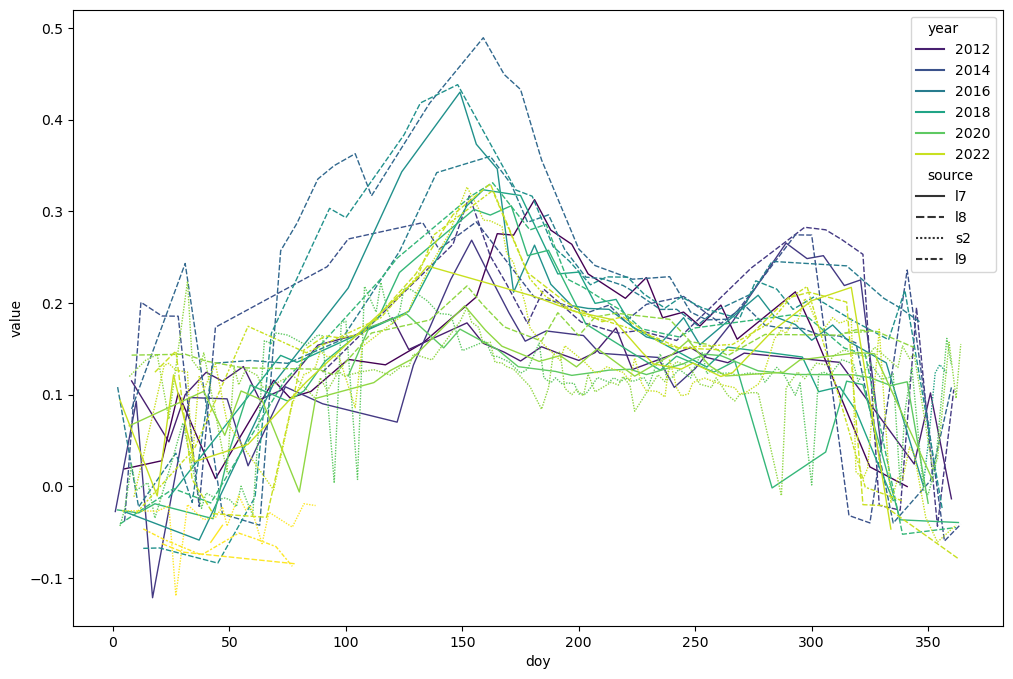

In [523]:
fig, ax = plt.subplots(figsize=(12, 8));
g = sns.lineplot(data=df_plot, x="doy", y="value", hue="year", style="source", estimator=None, lw=1, palette='viridis', ax=ax)
# g = sns.lineplot(data=df_plot, x="doy", y="value_smoothed", hue="year", style="source", estimator=None, lw=1, palette='viridis', ax=ax)

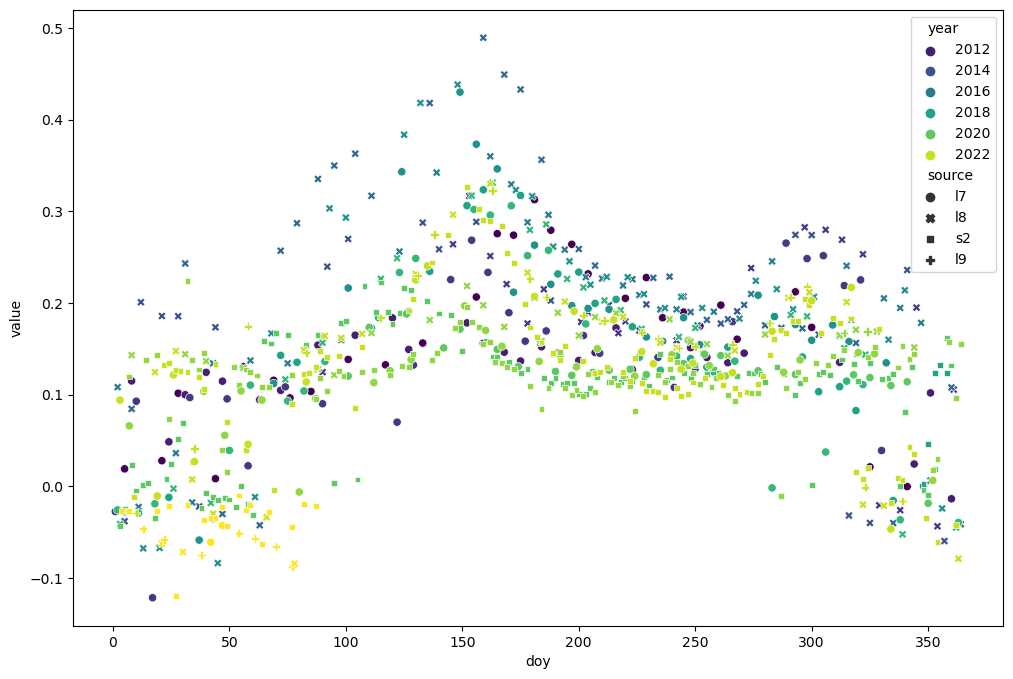

In [524]:
fig, ax = plt.subplots(figsize=(12, 8));
g = sns.scatterplot(data=df_plot, x="doy", y="value", hue="year", style="source", palette='viridis', ax=ax)

In [525]:
df_plot = df_long.query("reducer =='mean' and date.dt.year >= 2015 and variable == 'NDVI'")

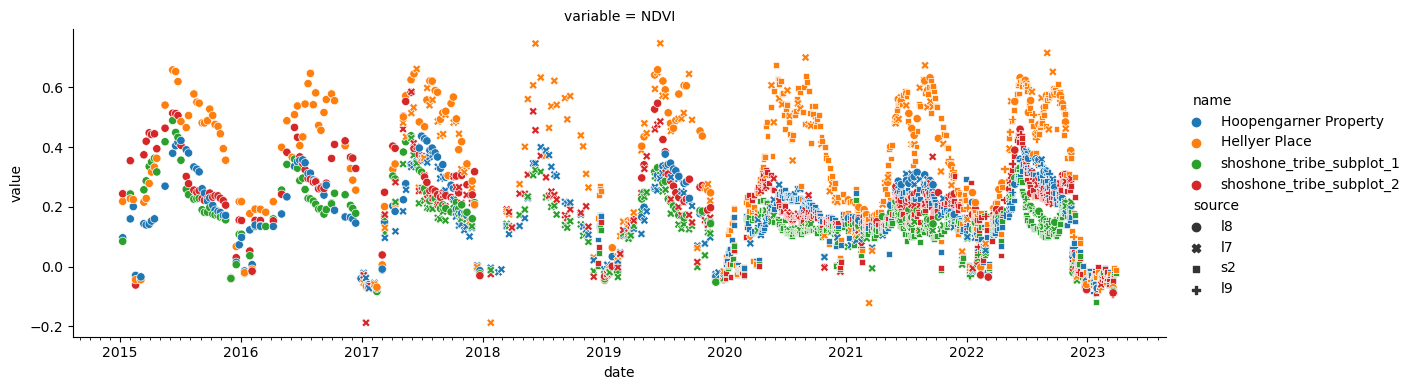

In [526]:
g = sns.relplot(
    data=df_plot,
    x="date",
    y="value",
    hue="name",
    style="source",
    col="variable",
    col_wrap=1,
    kind="scatter",
    height=4,
    aspect=3,
    facet_kws=dict(sharey=False),
)

for ax in g.axes:
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator())